# Interactive plots of cell states vs storage for ResOps reservoirs

In [1]:
import os
print(f'Old working directory: {os.getcwd()}')
# change directory out of subdirectory 'experiments'
os.chdir('..')
print(f'Current working directory: {os.getcwd()}')

Old working directory: c:\Users\mattc\Documents\DL-reservoir-modeling\experiments
Current working directory: c:\Users\mattc\Documents\DL-reservoir-modeling


In [2]:
%matplotlib widget

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, TwoSlopeNorm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from math import floor
import seaborn as sns
from scipy import stats
from scipy.stats import theilslopes
import geopandas as gpd
import os
import copy
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.basemap import Basemap
import mplcursors

from src.data.data_processing import *
from src.data.data_fetching import *
from src.models.model_zoo import *
from src.models.predict_model import *
from src.models.train_model import *
from src.data.implied_storage import get_implied_storage
from src.models.analyze_lstm_cell import *

In [4]:
def data_processing(id, transform_type, left, right=None, train_frac=0.6, val_frac=0.2, test_frac=0.2, return_scaler=False, storage=False):
    """
    Run data processing pipeline for one ResOPS/USBR reservoir.
    Params:
    id -- str, ResOPS reservoir ID (numeric) or USBR name (character)
    transform_type -- str, in preprocessing, whether to 'standardize' or 'normalize' the data
    left -- str (YYYY-MM-DD), beginning boundary of time window
    right -- str (YYYY-MM-DD), end boundary of time window. By default, '2020-12-31' for ResOPS and '2022-12-31' for USBR
    return_scaler -- bool, whether or not to return src.data.data_processing.time_scaler() object
    storage -- bool, whether or not to include storage data in features
    """

    # Read in data, columns are [inflow, outflow, storage]
    if id.isdigit():
        df = resops_fetch_data(res_id=id, vars=['inflow', 'outflow', 'storage'])
        right = '2020-12-31' if right is None else right # Default right window for ResOPS
    else:
        df = usbr_fetch_data(name=id, vars=['inflow', 'outflow', 'storage'])
        right = '2022-12-31' if right is None else right # Default right window for USBR

    # Add day of the year (doy) as another column
    df['doy'] = df.index.to_series().dt.dayofyear
    # Select data window
    df = df[left:right].copy()

    # Run data processing pipeline
    pipeline = processing_pipeline(train_frac=train_frac, val_frac=val_frac, test_frac=test_frac, chunk_size=3*365, pad_value=-1, transform_type=transform_type, fill_na_method='mean')
    # Train/val/test tensors of shape (#chunks, chunksize, [inflow, outflow, storage, doy])
    ts_train, ts_val, ts_test = pipeline.process_data(df) 

    # Separate inputs(X) and targets (y)
    if storage:
        X_train, X_val, X_test = ts_train[:, :, [0, 2, 3]], ts_val[:, :, [0, 2, 3]], ts_test[:, :, [0, 2, 3]]
    else:
        X_train, X_val, X_test = ts_train[:, :, [0, 3]], ts_val[:, :, [0, 3]], ts_test[:, :, [0, 3]]
    # select outflow as target feature
    y_train, y_val, y_test = ts_train[:, :, [1]], ts_val[:, :, [1]], ts_test[:, :, [1]]

    if return_scaler:
        return (X_train, y_train), (X_val, y_val), (X_test, y_test), pipeline.scaler
    else:
        return (X_train, y_train), (X_val, y_val), (X_test, y_test)



def load_resops_model(res_id, model_num=1, path=None):
    """ 
    Load trained manual unroll LSTM (Model 1-4) for one ResOPS reservoir
    Params:
    res_id -- int, ResOPS reservoir ID
    model_num -- int, which manual unroll model to load (1-4)
    path -- default None (load weights from unroll ResOPS model), if provided, ignore res_id input and load model directly from provided path. If 'initialize', return initialized model.
    """
    input_size = 2 # inflow, doy

    if model_num == 1: # Model 1 (manual unroll)
        hidden_size1 = 30
        hidden_size2 = 15
        output_size = 1 # outflow
        dropout_prob = 0.3
        num_layers = 1

        torch.manual_seed(0)
        model = LSTMModel1(input_size=input_size, hidden_size1=hidden_size1, 
                                    hidden_size2=hidden_size2, output_size=output_size, num_layers=num_layers, dropout_prob=dropout_prob)
    
    elif model_num == 2:
        hidden_size1 = 35
        hidden_size2 = 20
        num_layers = 1
        output_size = 1
        dropout_prob = 0.3

        torch.manual_seed(0)
        model = LSTMModel2(input_size=input_size, hidden_size1=hidden_size1, 
                                    hidden_size2=hidden_size2, num_layers=num_layers, output_size=output_size, dropout_prob=dropout_prob, initial_output=0)
    
    elif model_num == 3:
        hidden_size1 = 35
        hidden_size2 = 15
        num_layers = 1
        output_size = 1
        dropout_prob = 0.3

        torch.manual_seed(0)
        model = LSTMModel3(input_size=input_size, hidden_size1=hidden_size1, 
                                    hidden_size2=hidden_size2, output_size=output_size, num_layers=num_layers, dropout_prob=dropout_prob, initial_output=0, initial_implied_storage=0)
    
    elif model_num == 4:
        hidden_size = 50
        output_size = 1
        dropout_prob = 0.7
        torch.manual_seed(0)
        model = resRNN(input_size=input_size, hidden_size=hidden_size, output_size=output_size,
                    dropout_prob=dropout_prob)
    
    # Load model weights
    if path is None:
        model.load_state_dict(torch.load(f'src/models/saved_models/resops_unroll_models/resops_model{model_num}_{res_id}.pt', weights_only=True))
    elif path == 'initialize':
        pass
    else:
        model.load_state_dict(torch.load(path, weights_only=True))
    model.eval()
    return model

def correlate_cell_storage(id, model, left_year, return_data=False, add_linear_probe=True):
    """
    Get train/val/test cell state vs observed storage correlations
    Params:
    id - str, ResOPS reservoir ID (numeric) or USBR name (character)
    left_year - left and year window for data processing, i.e. for ResOPS from get_left_years(res_list)[res_id].
    return_data - also return train/val/test split df, cell states, and data tensors (default False)
    add_linear_probe - whether or not to train a linear probe and return the correlation of the probe to observed storage (default True)
    Returns:
    df of cell state - storage correlations for train/val/test data (each of (hidden_size, 3))
    """
    # Get split df data (fill NA with training mean)
    df_train, df_val, df_test = split_df_data(id=id, left=f'{left_year}-01-01', data_splits=(0.6, 0.2, 0.2), fill_train_mean=True)
    # Data processing
    (X_train, y_train), (X_val, y_val), (X_test, y_test) = data_processing(id=id, transform_type='standardize',
                                                        left=f'{left_year}-01-01', return_scaler=False, storage=False)

    # Get hidden and cell states, result is list with one tensor for each layer, shape is (# chunks, timesteps, hidden size)
    with torch.no_grad():
        hidden_train, cell_train = model(X_train)[1]
        hidden_val, cell_val = model(X_val)[1]
        hidden_test, cell_test = model(X_test)[1]

    # Calculate correlations for layer 1
    correlation_data = {'train':cell_correlations(cell_states=cell_train[0], storage_states=df_train.storage.values),
                        'val': cell_correlations(cell_states=cell_val[0], storage_states=df_val.storage.values),
                        'test': cell_correlations(cell_states=cell_test[0], storage_states=df_test.storage.values)}
    df_corr = pd.DataFrame(correlation_data)

    # Add linear probe correlation (optional)
    if add_linear_probe:
        probe = cell_linear_probe()
        probe.fit_probe(cell_train[0], df_train.storage.values)
        df_corr.loc['linear_probe', :] = [probe.correlate_prediction(cell_train[0], df_train.storage.values), 
                                          probe.correlate_prediction(cell_val[0], df_val.storage.values), 
                                          probe.correlate_prediction(cell_test[0], df_test.storage.values)]
    
    if return_data:
        return df_corr, {'df_splits': (df_train, df_val, df_test), 'cell_splits': (cell_train, cell_val, cell_test), 'tensor_splits': (X_train, X_val, X_test, y_train, y_val, y_test)}
    else:
        return df_corr
    
def correlate_storage_outflow_all():
    """Get pearson correlation between storage and outflow (test data) for each reservoir in res_list"""
    res_list = filter_res()
    left_years_dict = get_left_years(res_list=res_list)
    corrs = []
    for res in res_list:
        # Get split df data
        df_train, df_val, df_test = split_df_data(id=res, left=f'{left_years_dict[res]}-01-01', data_splits=(0.6, 0.2, 0.2))
        df_test.dropna(axis=0, inplace=True)
        corrs.append(stats.pearsonr(df_test.outflow.values, df_test.storage.values)[0])
    return pd.DataFrame(corrs, index=res_list, columns=['outflow_storage_corr'])

def correlate_storage_inflow_all():
    """Get pearson correlation between storage and inflow (test data) for each reservoir in res_list"""
    res_list = filter_res()
    left_years_dict = get_left_years(res_list=res_list)
    corrs = []
    for res in res_list:
        # Get split df data
        df_train, df_val, df_test = split_df_data(id=res, left=f'{left_years_dict[res]}-01-01', data_splits=(0.6, 0.2, 0.2))
        df_test.dropna(axis=0, inplace=True)
        corrs.append(stats.pearsonr(df_test.inflow.values, df_test.storage.values)[0])
    return pd.DataFrame(corrs, index=res_list, columns=['inflow_storage_corr'])

In [5]:
## Get df_result summary for all reservoirs

left_year_dict = get_left_years(res_list=filter_res())

# Read correlation results for Model 1
df_corr_test_model1 = pd.read_csv('report/results/resops_training/resops_unroll_models/cell_storage_correlations/cell_storage_corr_model1_test.csv', index_col=0)
# Maximum absolute correlations on test data (for model 1, last index is for linear probe)
df_corr_max_test = pd.DataFrame({'model1_max_cell_sto_corr': df_corr_test_model1.iloc[:-1, :].abs().max(axis=0)})
# Correlations of linear probe for model 1 on test data
df_corr_probe_test = pd.DataFrame({'model1_linear_probe_corr': df_corr_test_model1.iloc[-1, :].abs()})

# Fetch GPS coordinates of reservoirs, join with correlations results
coords_all = pd.read_csv('data/ResOpsUS/attributes/reservoir_attributes.csv', index_col=0)[['LONG', 'LAT']]
coords_all.index = coords_all.index.astype(str)
df_corr_coords = df_corr_probe_test.join(other=coords_all, how='left')
df_corr_coords = df_corr_coords.join(other=df_corr_max_test, how='left')

# Get main use from GRanD
gdf = gpd.read_file("data/GRanD/GRanD_dams_v1_3.shp")
gdf = gdf.drop(columns="geometry").set_index("GRAND_ID")
main_use = gdf[["MAIN_USE"]]
main_use.index = main_use.index.astype(str)

# Read in ResOPS attributes (mean inflow, max storage, model 1 test r2)
df_result = pd.read_csv('report/results/resops_training/resops_attributes_r2.csv', index_col=0).loc[:, ['mean_inflow', 'max_storage', 'test']]
df_result.index = df_result.index.astype(str)

# Calculate mean inflow / max storage metric
df_result = pd.concat([df_result,
                       correlate_storage_outflow_all(),
                       correlate_storage_inflow_all()], axis=1, join='outer')
df_result.columns = ['mean_inflow', 'max_storage', 'model1_test_r2', 'outflow_storage_corr', 'inflow_storage_corr']
df_result['log_mean_in_max_sto'] = np.log(df_result['mean_inflow'] / df_result['max_storage'])
df_result['log_mean_in_max_sto_cat'] = pd.cut(df_result['log_mean_in_max_sto'], bins=[-np.inf,-3.79, -3.17, -2.46, np.inf], labels=['very_high', 'high', 'medium', 'low'])

# Join with max cell-storage correlations from Model 1/2, join with main use from GRanD
df_result = df_result.join(other=df_corr_coords, how='inner').join(other=main_use, how='left')
# Drop performance outliers
df_result = df_result.drop(index=['1249', '939', '597']) 

In [6]:
def plot_probe_storage(id, model, left_year, ax, return_data=False):
    """ 
    For a given reservoir ID, plot linear probe predictions vs. observed storage.
    Params:
    id - str, ResOPS/USBR id to plot for
    model - LSTM model to evaluate cell states from
    left_year - left year window for data processing, i.e. from get_left_years(res_list)[res_id]
    ax - matplotlib axes to plot on
    """
    df_corr, data = correlate_cell_storage(id=id, model=model, left_year=left_year, return_data=True)
    storage_test = data['df_splits'][2].storage.values
    ax.plot((storage_test - storage_test.mean()) / storage_test.std()) # plot standardized observed storage (test data)

    probe = cell_linear_probe()
    probe.fit_probe(cell_states=data['cell_splits'][0][0], storage_state=data['df_splits'][0].storage.values) # fit probe on training data
    probe_pred_test = probe.predict(data['cell_splits'][2][0])[:len(data['df_splits'][2])] # probe predictions on test data
    ax.plot((probe_pred_test - probe_pred_test.mean()) / probe_pred_test.std()) # standardize probe predictions and plot

    ax.legend(['observed storage', rf'linear probe (r={round(df_corr.loc["linear_probe", "test"], 2)})'], loc='upper left')

    if return_data:
        return df_corr, data

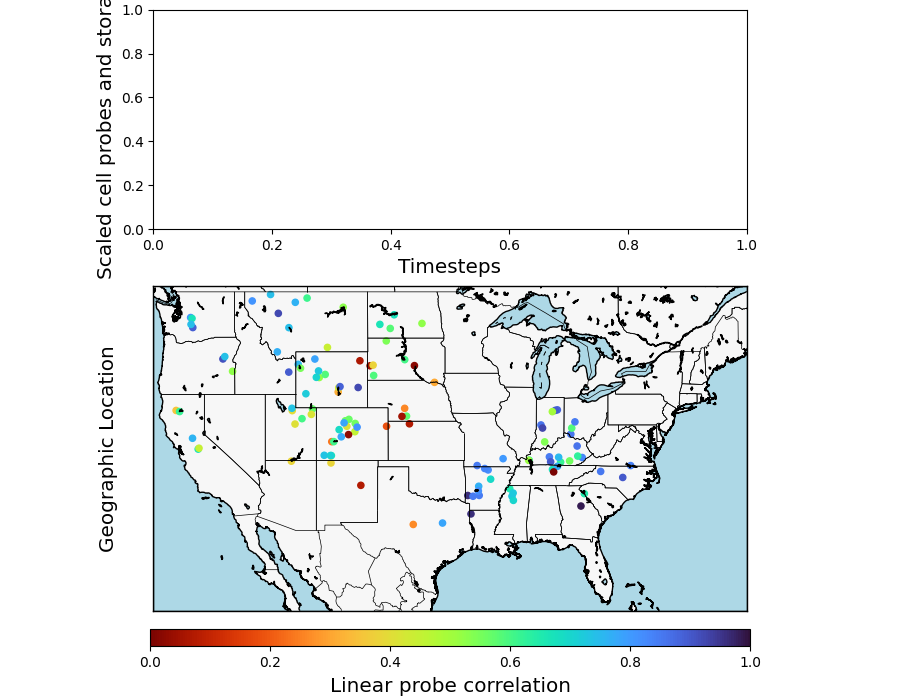

In [10]:
fig, axes = plt.subplots(nrows=2, figsize=(9, 7), constrained_layout=True, gridspec_kw={'height_ratios': [1, 1.48]})
axes[0].set_box_aspect(0.37)
axes[0].set_xlabel("Timesteps", size='x-large')
axes[0].set_ylabel("Scaled cell probes and storages", size='x-large')

# Plot map of linear probe correlations (test data)
map = Basemap(projection='merc', llcrnrlat=24.396308, urcrnrlat=49.384358,
              llcrnrlon=-125.001650, urcrnrlon=-66.934570, resolution='i', ax=axes[1])
map.drawcoastlines()
map.drawcountries()
map.drawstates()
map.fillcontinents(color='#f7f7f7', lake_color='lightblue')
map.drawmapboundary(fill_color='lightblue')
# Convert lat/long to map projection coordinates
x, y = map(df_corr_coords['LONG'], df_corr_coords['LAT'])
# Scatter plot with color coding
sc = map.scatter(x, y, c=df_corr_coords['model1_linear_probe_corr'], 
                 vmin=0, vmax=1, cmap='turbo_r', s=20, ax=axes[1])
axes[1].set_ylabel("Geographic Location", size='x-large', labelpad=25)

# Add probe-storage plot (axes[0]) on click
cursor = mplcursors.cursor(sc, hover=False, multiple=False)  # click to show; set hover=True for tooltip-on-hover
@cursor.connect("add")
def on_add(sel):
    i = sel.index                           # index into the scatter's points
    label = str(df_corr_coords.index[i])    # your "label" is the DataFrame index
    sel.annotation.set_text(label)
    # (optional) styling
    sel.annotation.get_bbox_patch().set(fc="white", alpha=0.9)

    axes[0].clear()  # Clear the previous plot
    plot_probe_storage(id=label, model=load_resops_model(res_id=label, model_num=1), left_year=left_year_dict[label], ax=axes[0])
    axes[0].set_title(f'Reservoir {label} (test $R^2$={round(df_result.loc[label, 'model1_test_r2'], 2)})', size='x-large')

# Add a colorbar
cbar = plt.colorbar(sc, ax=[axes[1]], orientation='horizontal', shrink=0.673, aspect=35)
fig.supxlabel("Linear probe correlation", size='x-large')
plt.show()

In [8]:
def lobf(x, y, ax):
    """Plot line of best fit"""
    #Find line of best fit
    a, b = np.polyfit(x, y, 1)
    #Add line of best fit to plot
    ax.plot(x, a*x+b, color='red')
    return

def correlate(x, y):
    """Return pearson correlation"""
    return stats.pearsonr(x, y)[0]

def correlate_pval(x, y, alt='two-sided', n_resamples=10000):
    """
    Return pval testing significance of correlation coefficient using permutation testing
    Params:
    x, y: data arrays to calculate correlation between
    alt: str, 'greater', 'less', or 'two-sided'. The alternative hypothesis
    n_resamples: int, number of permutations used to approximate null distribution
    Return:
    r - float, Pearson's correlation between x and y
    pvalue - p-value from permutation testing
    """
    # Calculate correlation between x and y and permuation test p-value
    res = stats.permutation_test((x, y), correlate, vectorized=False,
                        permutation_type='pairings',
                        alternative=alt,
                        n_resamples=n_resamples,
                        random_state=0)
    r, pvalue, null = res.statistic, res.pvalue, res.null_distribution
    return r, pvalue

c:\Users\mattc\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_resampling.py:1498: RuntimeWarning: overflow encountered in scalar power
  n_max = factorial(n_obs_sample)**n_samples


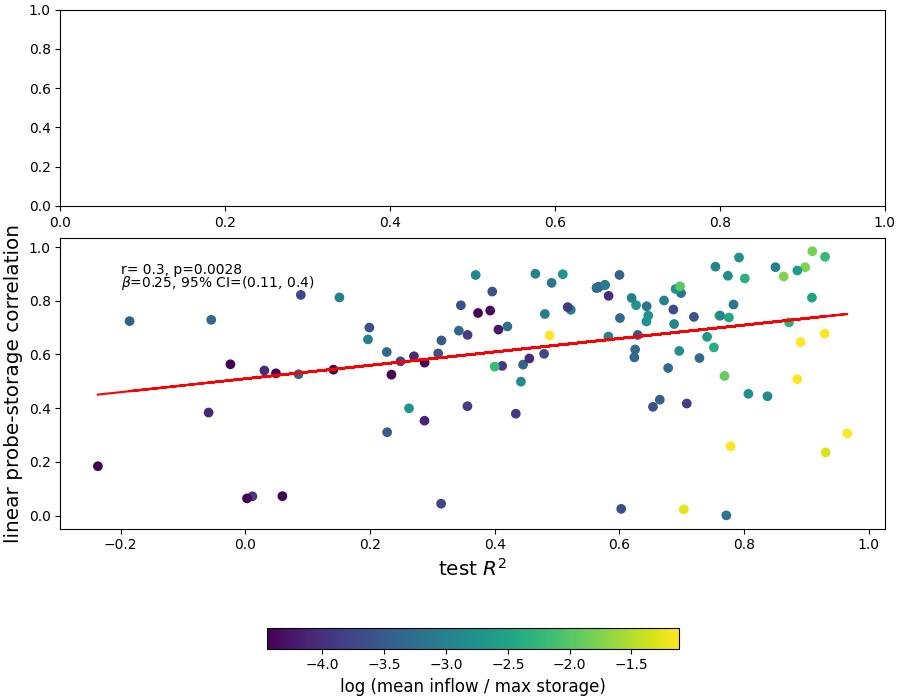

In [11]:
fig, axes = plt.subplots(nrows=2, figsize=(9, 7), constrained_layout=True, gridspec_kw={'height_ratios': [1, 1.48]})

vars = [df_result['model1_test_r2'], np.abs(df_result['model1_max_cell_sto_corr']), df_result['log_mean_in_max_sto'], df_result['model1_linear_probe_corr']]
var_names = ['test $R^2$', 'max cell-storage correlation', 'log (mean inflow / max storage)', 'linear probe-storage correlation']

## R2 vs linear probe R2
norm = Normalize(vmin=np.percentile(vars[2], 5), vmax=np.percentile(vars[2], 95))
sc = axes[1].scatter(x=vars[0], y=vars[3], c=vars[2], cmap='viridis', norm=norm)
handles, labels = axes[1].get_legend_handles_labels()
axes[1].set_xlabel(var_names[0], size='x-large')
axes[1].set_ylabel(var_names[3], size='x-large')
lobf(vars[0], vars[3], axes[1])
# Add correlation and p-value
corr, pval = correlate_pval(vars[0], vars[3])
axes[1].text(-0.2, 0.9, r'r='+f' {round(corr, 2)}, p={round(pval, 6)}', size='medium')
# Theil-Sen slope and 95 CI
slope, intercept, lo, hi = theilslopes(vars[3], vars[0], alpha=0.95)
axes[1].text(-0.2, 0.85, fr'$\beta$={round(slope, 2)}, 95% CI=({round(lo, 2)}, {round(hi, 2)})', size='medium')

# Add colorbar
cbar = fig.colorbar(sc, ax=axes[1], orientation='horizontal', pad=0.15, shrink=0.5)
cbar.set_label(var_names[2], size='large')
cbar.ax.tick_params(labelsize='medium')
plt.show()

# Add probe-storage plot (axes[0]) on click
cursor = mplcursors.cursor(sc, hover=False, multiple=False)  # click to show; set hover=True for tooltip-on-hover
@cursor.connect("add")
def on_add(sel):
    i = sel.index                           # index into the scatter's points
    label = str(df_result.index[i])    # your "label" is the DataFrame index
    sel.annotation.set_text(label)
    # (optional) styling
    sel.annotation.get_bbox_patch().set(fc="white", alpha=0.9)

    axes[0].clear()  # Clear the previous plot
    plot_probe_storage(id=label, model=load_resops_model(res_id=label, model_num=1), left_year=left_year_dict[label], ax=axes[0])
    axes[0].set_title(f'Reservoir {label} (test $R^2$={round(df_result.loc[label, 'model1_test_r2'], 2)})', size='x-large')
